# ECBM E4040  Assignment 1, Task 2: Multilayer Perceptron (MLP)
This is the second part of the assignment. You will get to know how to build basic fully connected neural network.

In [2]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from ecbm4040.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [3]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions


In [4]:
from ecbm4040.layer_funcs import affine_forward
from ecbm4040.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Instructions for updating:
Colocations handled automatically by placer.
Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


In [5]:
from ecbm4040.layer_funcs import relu_forward
from ecbm4040.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)
## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


In [6]:
from ecbm4040.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)


## tensorflow gradients
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

In [7]:
## First, let's make a dense layer
from ecbm4040.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients


## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.nn.relu(tf.matmul(x_tf,w_tf) + b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


In [8]:
from ecbm4040.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation


In [9]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

## Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4*L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [10]:
from ecbm4040.train_funcs import train, test

#### Start training

In [13]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

## Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, optim='SGD', verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 3.4903903001606884
10000/49000 loss: 2.8930689869419033
15000/49000 loss: 2.329855018529476
20000/49000 loss: 2.3420764399545506
25000/49000 loss: 2.292263367023682
30000/49000 loss: 2.251937499699058
35000/49000 loss: 2.2138853577555797
40000/49000 loss: 2.2020462593880112
45000/49000 loss: 2.177559503281607
epoch 1: valid acc = 0.221, new learning rate = 0.000475
5000/49000 loss: 2.1657008244770086
10000/49000 loss: 2.1587202185732224
15000/49000 loss: 2.0679746822132765
20000/49000 loss: 2.028332517671132
25000/49000 loss: 2.0124586899346855
30000/49000 loss: 1.971755179537809
35000/49000 loss: 2.0185745774710298
40000/49000 loss: 2.0037394372625035
45000/49000 loss: 1.9721288051149715
epoch 2: valid acc = 0.278, new learning rate = 0.00045125
5000/49000 loss: 1.9672842490320355
10000/49000 loss: 1.9169120639818245
15000/49000 loss: 1.9758052098817158
20000/49000 loss: 1.9084302053609161
25000/49000 loss: 1.8689368381620601
30000/4

0.4415

Training and validation accuracy history of each epoch

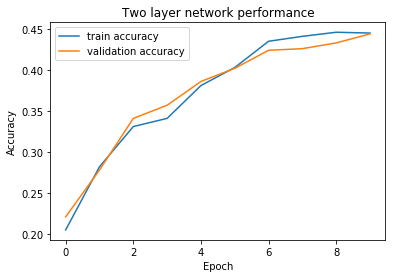

In [14]:
# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Two layer network performance")
plt.savefig("images/twolayernetwork.png")
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [15]:
from ecbm4040.display_funcs import visualize_pics

num of feature vectors: 100


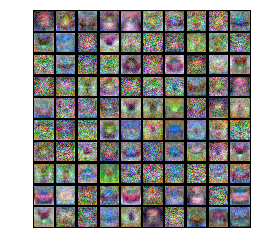

In [16]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Get test accuracy greater than 50%


In [17]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet
# Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to below, using your parameter specs:
#    model = TwoLayerNet(input_dim=TBD, hidden_dim=TBD, num_classes=TBD, reg=TBD, weight_scale=TBD)
#    num_epoch = TBD
#    batch_size = TBD
#    lr = TBD
#    verbose = TBD
#    train_acc_hist, val_acc_hist = train(TBD)
#    test(TBD, TBD, TBD)
model = TwoLayerNet(input_dim=3072, hidden_dim=200, num_classes=10, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 100
lr = 5e-4
verbose = True

train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, optim='SGD', verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 490
1000/49000 loss: 10.964845542021099
2000/49000 loss: 4.542354395849212
3000/49000 loss: 2.2446369224548235
4000/49000 loss: 2.5056507419980916
5000/49000 loss: 2.428265164085321
6000/49000 loss: 2.1521200532227627
7000/49000 loss: 2.166054240709625
8000/49000 loss: 2.179914101936292
9000/49000 loss: 2.125464299711841
10000/49000 loss: 2.0967419339299385
11000/49000 loss: 2.1058709020192583
12000/49000 loss: 2.1685566607448523
13000/49000 loss: 2.0215628812052118
14000/49000 loss: 2.0351786816108937
15000/49000 loss: 1.9403302414304595
16000/49000 loss: 1.9646235936733905
17000/49000 loss: 1.9836755523368093
18000/49000 loss: 1.9343713325752137
19000/49000 loss: 1.8883579414835665
20000/49000 loss: 1.8482077531430177
21000/49000 loss: 2.009289876028031
22000/49000 loss: 1.9458892432523598
23000/49000 loss: 1.7817719547816635
24000/49000 loss: 1.971236453352
25000/49000 loss: 1.904201962914778
26000/49000 loss: 1.908784159538287
27000/49000 loss: 1.763

22000/49000 loss: 1.3890152745678135
23000/49000 loss: 1.3906904309748307
24000/49000 loss: 1.3708497639476007
25000/49000 loss: 1.269694343373177
26000/49000 loss: 1.4390900611526996
27000/49000 loss: 1.4111700605737367
28000/49000 loss: 1.3574918480933353
29000/49000 loss: 1.4112766297159547
30000/49000 loss: 1.14942043242262
31000/49000 loss: 1.540727301106518
32000/49000 loss: 1.3483367344977473
33000/49000 loss: 1.4845310407831336
34000/49000 loss: 1.5511914835272325
35000/49000 loss: 1.27363913260167
36000/49000 loss: 1.3107536316881943
37000/49000 loss: 1.3541065167774013
38000/49000 loss: 1.2464674749089457
39000/49000 loss: 1.3731576987700806
40000/49000 loss: 1.1945840143193962
41000/49000 loss: 1.2949792801501745
42000/49000 loss: 1.101128787240409
43000/49000 loss: 1.443077679481273
44000/49000 loss: 1.2934579447099166
45000/49000 loss: 1.4258248061696668
46000/49000 loss: 1.6424345939263947
47000/49000 loss: 1.3306174429678717
48000/49000 loss: 1.3013894071221457
49000/490

43000/49000 loss: 1.1078956109388902
44000/49000 loss: 1.2943733145257086
45000/49000 loss: 1.1799013989882026
46000/49000 loss: 1.0765448090684409
47000/49000 loss: 1.112032197237047
48000/49000 loss: 1.196317233303331
49000/49000 loss: 1.1363170665584619
epoch 9: valid acc = 0.516, new learning rate = 0.0003151247048623045
1000/49000 loss: 1.2294126905638905
2000/49000 loss: 1.0201610494353968
3000/49000 loss: 1.114291238156045
4000/49000 loss: 1.2224811632683745
5000/49000 loss: 1.1767212014166784
6000/49000 loss: 1.153605672733944
7000/49000 loss: 1.1718207629248345
8000/49000 loss: 1.068025311789699
9000/49000 loss: 1.2378227734787366
10000/49000 loss: 1.2973860219355777
11000/49000 loss: 1.1444153368308294
12000/49000 loss: 1.2146759346913274
13000/49000 loss: 1.3578143417413244
14000/49000 loss: 1.2558971092623818
15000/49000 loss: 1.1912041071382886
16000/49000 loss: 1.202094561551671
17000/49000 loss: 1.2618825471300263
18000/49000 loss: 1.2439971919696107
19000/49000 loss: 1.

0.4961

Best result, including accuracy and weights of the first layer

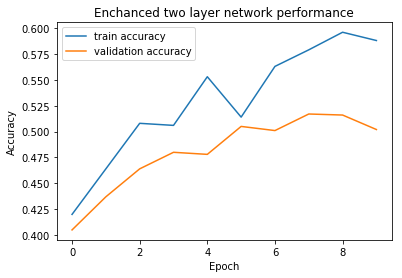

In [18]:
## plot training and validation accuracy
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Enchanced two layer network performance")
plt.savefig("images/twolayernetwork.png")
plt.show()

num of feature vectors: 200


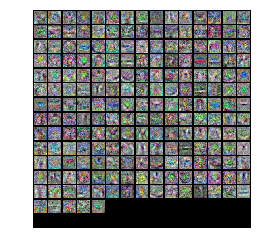

In [19]:
## Visualize weights
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Save your best model in a dictionary 

In [20]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

## Part 3: Multilayer Net 


In [21]:
from ecbm4040.classifiers.mlp import MLP

## Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
epoch 1: valid acc = 0.094, new learning rate = 0.0095
epoch 2: valid acc = 0.164, new learning rate = 0.009025
epoch 3: valid acc = 0.235, new learning rate = 0.00857375
epoch 4: valid acc = 0.287, new learning rate = 0.0081450625
epoch 5: valid acc = 0.358, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.369, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.379, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.426, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.441, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.449, new learning rate = 0.005987369392383786
test acc: 0.4491


0.4491

## Part 4: Tensorflow MLP


In [22]:
## Demo: Two-layer net in tensorflow.
hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.17499999701976776
epoch 2: valid acc = 0.3179999887943268
epoch 3: valid acc = 0.4000000059604645
epoch 4: valid acc = 0.4320000112056732
epoch 5: valid acc = 0.45399999618530273
epoch 6: valid acc = 0.46399998664855957
epoch 7: valid acc = 0.47200000286102295
epoch 8: valid acc = 0.4830000102519989
epoch 9: valid acc = 0.49300000071525574
epoch 10: valid acc = 0.5
test acc = 0.5


Create MLP in tensorflow

In [23]:

hidden_dim = 100
reg_tf = tf.constant(0.01)

weights = {
    'w1': tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32')),
    'w2': tf.Variable(1e-2*np.random.rand(hidden_dim, hidden_dim).astype('float32')),
    'w3': tf.Variable(1e-2*np.random.rand(hidden_dim, hidden_dim).astype('float32')),
    'w4': tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32')),
    'b1': tf.Variable(np.zeros((hidden_dim,)).astype('float32')),
    'b2': tf.Variable(np.zeros((hidden_dim,)).astype('float32')),
    'b3': tf.Variable(np.zeros((hidden_dim,)).astype('float32')),
    'b4': tf.Variable(np.zeros((10,)).astype('float32'))
}


x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

h1_tf = tf.nn.relu(tf.matmul(x_tf, weights['w1']) + weights['b1'])
h2_tf = tf.nn.relu(tf.matmul(h1_tf, weights['w2']) + weights['b2'])
h3_tf = tf.nn.relu(tf.matmul(h2_tf, weights['w3']) + weights['b3'])
h4_tf = tf.matmul(h1_tf, weights['w4']) + weights['b4']

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h4_tf, labels=tf.one_hot(y_tf,10))

L2_loss = 0.0
for i in range(1,5):
    w_iter = 'w'+str(i)
    L2_loss += tf.nn.l2_loss(weights[w_iter])
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h4_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.21400000154972076
epoch 2: valid acc = 0.3240000009536743
epoch 3: valid acc = 0.3610000014305115
epoch 4: valid acc = 0.4009999930858612
epoch 5: valid acc = 0.4230000078678131
epoch 6: valid acc = 0.4320000112056732
epoch 7: valid acc = 0.4480000138282776
epoch 8: valid acc = 0.46799999475479126
epoch 9: valid acc = 0.47600001096725464
epoch 10: valid acc = 0.47600001096725464
test acc = 0.47600001096725464
